In [57]:
# get net monthly prior fluxes, to look at seasonal cycles of fluxes

In [58]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [59]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from util.functions import area_latlon # grid area in km^2
from util.gamap_colormap import WhGrYlRd

In [60]:
# Terrestrial, GEOS-Chem default
input_dir = '/geos/d21/GC_DATA/ExtData/HEMCO/'
fname = 'CO2/v2015-04/BIO/Net_terrestrial_exch_5.29Pg.generic.1x1.nc'
ds_ter  = xr.open_dataset(input_dir+fname)

# year 2000, annual mean
lat_res = ds_ter.attrs['Delta_Lat']
lon_res = ds_ter.attrs['Delta_Lon']
varname = 'CO2'
unit    = ds_ter[varname].attrs['units']
#ds_ter['CO2']

In [61]:
dr_gc = ds_ter[varname][0,:,:].copy()

In [62]:
# sum up global total
for ilat, lat in enumerate(dr_gc.lat):
    area_tmp = area_latlon(lat1 = lat, 
                            lon1 = dr_gc.lon[10].values, 
                            lat2 = lat + lat_res, 
                            lon2 = dr_gc.lon[10].values + lon_res)
    dr_gc[ilat,:] = dr_gc[ilat,:] * area_tmp *3600*24*366*1e6 # unit: kgCO2/yr
gc_total_original = dr_gc.copy() # plot later, kgCO2/yr/grid cell
total = dr_gc.sum()              # kgCO2/year, same as data description
ann_total = total.values         # kg/yr
ann_total_C_original = total.values*1e-12*12/44  # GtC/yr
    
print('annual total from this calculation:')
print(' ',ann_total_C_original)
print(' ')

annual total from this calculation:
  -5.269060654917819
 


In [63]:
# Biosphere, SiB3 balanced Net Ecosystem Production (NEP) CO2
input_dir = '/geos/d21/GC_DATA/ExtData/HEMCO/'
fname = 'CO2/v2015-04/BIO/SiB3_3hr_NEP.nc'
ds_bio  = xr.open_dataset(input_dir+fname)
# year range: 2006 - 2010, get 2010 for this calculation
lat_res = ds_bio.attrs['Delta_Lat']
lon_res = ds_bio.attrs['Delta_Lon']
varname = 'CO2'
unit    = ds_bio[varname].attrs['units']
#ds_bio

In [64]:
# selection a year of data
begin = 4*8*365 + 8 # 2010, last year available
end = 5*8*365 + 8
data = ds_bio[varname][begin:end,:,:].copy()
np.shape(data)

(2920, 181, 288)

In [65]:
for ilat, lat in enumerate(data.lat):
    area_tmp = area_latlon(lat1 = lat, 
                            lon1 = data.lon[10].values, 
                            lat2 = lat + lat_res, 
                            lon2 = data.lon[10].values + lon_res)
    data[:,ilat,:] = data[:,ilat,:]*area_tmp*3*3600*1e6 # unit: kgCO2/3hours
gc_total_sib = data.sum(dim = 'time')          # kgCO2/year, same as data description
annual_total = gc_total_sib.sum()
ann_total_sib = annual_total.values*1e-12*12/44 # GtC/yr
print('annual total from this calculation (PgC/yr):')
print(ann_total_sib)

annual total from this calculation (PgC/yr):
-0.060708582493090905


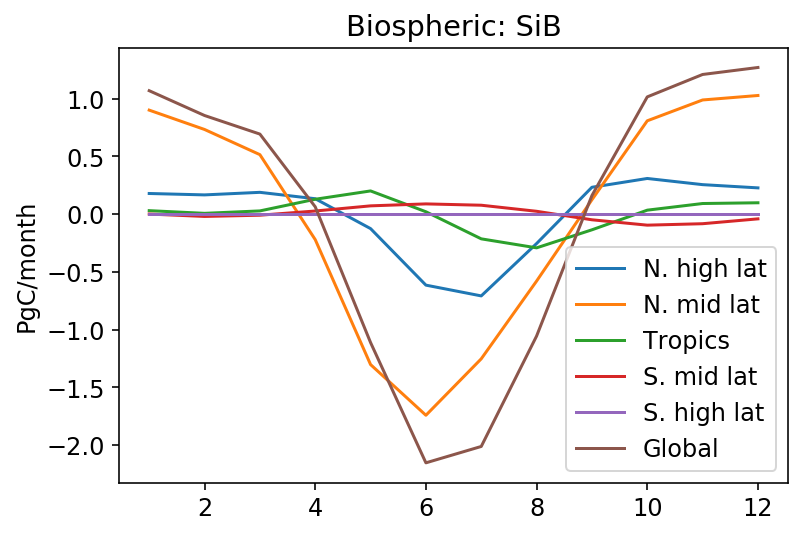

In [66]:
# SIB seasonal cycles
months = np.arange('2010-01', '2011-02', dtype='datetime64[M]')
nh = []
nm = []
tr = [] 
sm = []  
sh = []
gl = [] # global

for i in range(12):
    nh.append(data.sel(lat = slice(60,90), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    nm.append(data.sel(lat = slice(30,60), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    tr.append(data.sel(lat = slice(-30,30), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    sm.append(data.sel(lat = slice(-60,-30), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    sh.append(data.sel(lat = slice(-90,-60), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    gl.append(data.sel(time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    
sib_season = [nh,nm,tr,sm,sh,gl]
lab = ['N. high lat', 'N. mid lat', 'Tropics', 'S. mid lat', 'S. high lat', 'Global']
fig = plt.figure(figsize=[6, 4])
for i in range(len(sib_season)):
    plt.plot(range(1,13), sib_season[i], label = lab[i])
plt.ylabel('PgC/month')
#plt.ylim(-2,2)
plt.legend()
plt.title('Biospheric: SiB')

output_dir = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data'
fig.savefig(output_dir + '/monthly_bio.png', dpi = 300)

In [67]:
# ODIAC
input_dir = '/geos/d21/msadiq/ODIAC/'
lat_res = 1.
lon_res = 1.
varname1 = 'land'
varname2 = 'intl_bunker'

In [68]:
ds_odiac = xr.open_dataset(input_dir+'odiac2019_1x1d_2016.nc')
ds_odiac['land']

<xarray.DataArray 'land' (month: 12, lat: 180, lon: 360)>
[777600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:       gC/m2/d
    long_name:   ffco2_emission
    definition:  CO2 emissions from fossil fuel combustion, cememt production...

In [69]:

dr_odiac = ds_odiac[varname1] + ds_odiac[varname2]
days_in_month = [31,29,31,30,31,30,31,31,30,31,30,31]

for ilat, lat in enumerate(dr_odiac.lat):
    for imonth in range(12):
        area_tmp = area_latlon(lat1 = lat, 
                                lon1 = dr_odiac.lon[10].values, 
                                lat2 = lat + lat_res, 
                                lon2 = dr_odiac.lon[10].values + lon_res)
        dr_odiac[imonth,ilat,:] = dr_odiac[imonth,ilat,:] * area_tmp * days_in_month[imonth] *1e-3 # unit: kgCO2/month
odiac_annual = dr_odiac.sum(dim = 'month')*1e6
total = dr_odiac.sum()*1e6       # kgCO2/year, same as data description
ann_total_odiac = total.values*1e-12  # GtC/yr
    
ann_total_odiac

9.757697

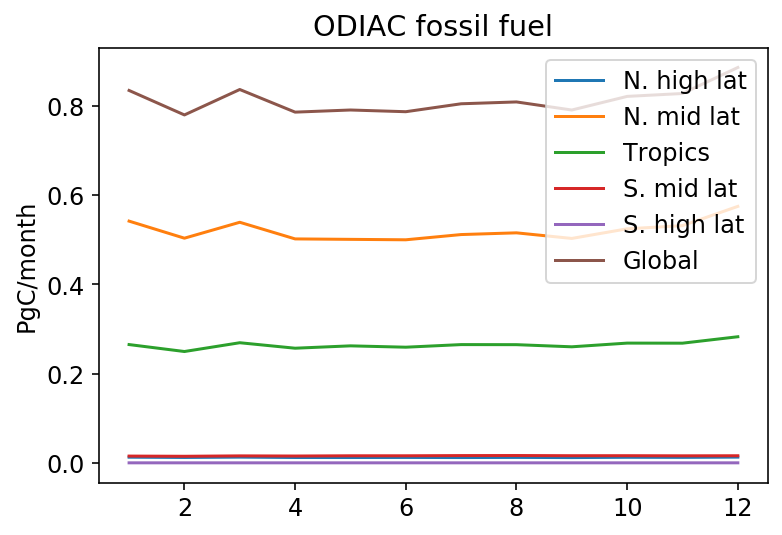

In [70]:
data = dr_odiac.copy()
# ODIAC seasonal cycle
nh = []
nm = []
tr = [] 
sm = []  
sh = []
gl = [] # global

for i in range(1,13):
    nh.append(data.sel(lat = slice(60,90), month = i).sum() *1e-6)
    nm.append(data.sel(lat = slice(30,60), month = i).sum() *1e-6)
    tr.append(data.sel(lat = slice(-30,30), month = i).sum() *1e-6)
    sm.append(data.sel(lat = slice(-60,-30), month = i).sum() *1e-6)
    sh.append(data.sel(lat = slice(-90,-60), month = i).sum() *1e-6)
    gl.append(data.sel(month = i).sum() *1e-6)
    
odiac_season = [nh,nm,tr,sm,sh,gl]
lab = ['N. high lat', 'N. mid lat', 'Tropics', 'S. mid lat', 'S. high lat', 'Global']
fig = plt.figure(figsize=[6, 4])
for i in range(len(odiac_season)):
    plt.plot(range(1,13), odiac_season[i], label = lab[i])
plt.ylabel('PgC/month')
plt.title('ODIAC fossil fuel')
#plt.ylim(-2,2)
plt.legend()

fig.savefig(output_dir + '/monthly_ff.png', dpi = 300)

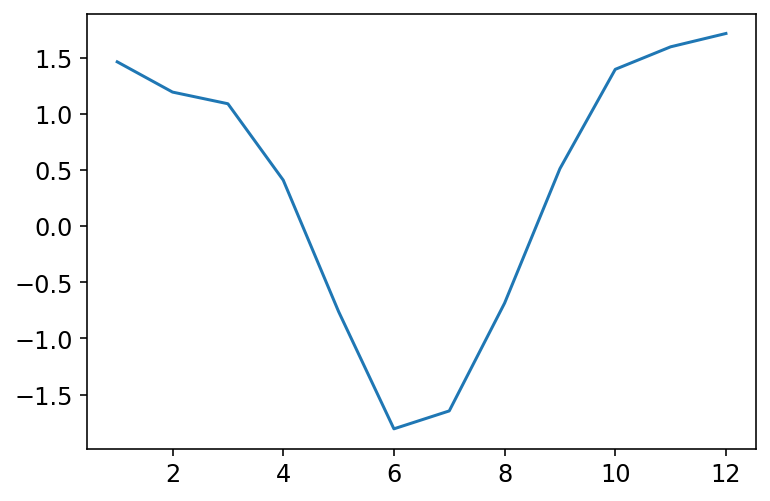

In [71]:
gl = []
for i in range(12):
    gl.append(sib_season[5][i] + odiac_season[5][i] + ann_total_C_original/12)
plt.plot(range(1,13), gl)

In [72]:
# ocean exchange
#filename = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2014-09/OCEAN/Taka2009_CO2_Annual.nc'
filename = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2014-09/OCEAN/Taka2009_CO2_Monthly.nc'
ds_ocean = xr.open_dataset(filename)
lat_res = ds_ocean.attrs['Delta_Lat']
lon_res = ds_ocean.attrs['Delta_Lon']
varname = 'CO2'
unit    = ds_ocean[varname].attrs['units']
dr_ocean = ds_ocean[varname]
ds_ocean

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 144, time: 12)
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float32 -89.5 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 89.5
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01
Data variables:
    CO2      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.5.5 (http://code.zmaw.de/p...
    Conventions:  COARDS
    history:      Fri Aug 22 10:45:34 2014: cdo mulc,7.30654e-22 tmp.nc Taka2...
    Title:        COARDS/netCDF file created by BPCH2COARDS (GAMAP v2-17+)
    Model:        GEOS4
    Delta_Lon:    2.5
    Delta_Lat:    2.0
    NLayers:      55
    Start_Date:   20000101
    Start_Time:   0
    End_Date:     20000101
    End_Time:     0
    Delta_Time:   0
    CDO:          Climate Data Operators version 1.5.5 (http://code.zmaw.de/p...

In [73]:

for ilat, lat in enumerate(dr_ocean.lat):
    for imonth in range(12):
        area_tmp = area_latlon(lat1 = lat, 
                                lon1 = dr_ocean.lon[10].values, 
                                lat2 = lat + lat_res, 
                                lon2 = dr_ocean.lon[10].values + lon_res)
        dr_ocean[imonth,ilat,:] = dr_ocean[imonth,ilat,:] * area_tmp * days_in_month[imonth] * 24 * 3600 *1e6  # unit: kgCO2/month
        #dr_ocean[0,ilat,:] = dr_ocean[0,ilat,:] * area_tmp * 24 *366 * 3600 *1e6  # unit: kgCO2/month
ocean_annual = dr_ocean.sum(dim = 'time')
total = dr_ocean.sum()       # kgCO2/year, same as data description
ann_total_ocean = total.values*1e-12*12/44  # GtC/yr
ann_total_ocean

-1.3727761098938183

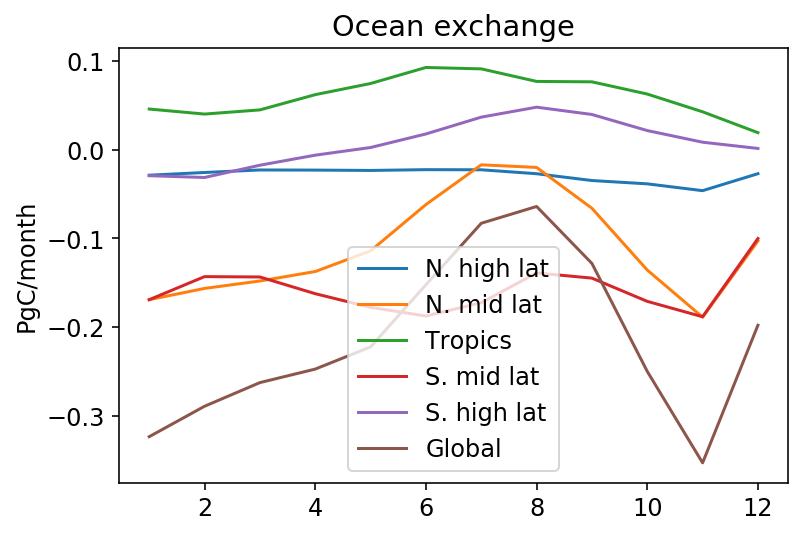

In [74]:
data = dr_ocean.copy()
# ocean exchange seasonal cycles
months = np.arange('2000-01', '2001-02', dtype='datetime64[M]')
nh = []
nm = []
tr = [] 
sm = []  
sh = []
gl = [] # global

for i in range(12):
    nh.append(data.sel(lat = slice(60,90), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    nm.append(data.sel(lat = slice(30,60), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    tr.append(data.sel(lat = slice(-30,30), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    sm.append(data.sel(lat = slice(-60,-30), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    sh.append(data.sel(lat = slice(-90,-60), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    gl.append(data.sel(time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    
ocean_season = [nh,nm,tr,sm,sh,gl]
lab = ['N. high lat', 'N. mid lat', 'Tropics', 'S. mid lat', 'S. high lat', 'Global']
fig = plt.figure(figsize=[6, 4])
for i in range(len(sib_season)):
    plt.plot(range(1,13), ocean_season[i], label = lab[i])
plt.ylabel('PgC/month')
plt.title('Ocean exchange')
#plt.ylim(-2,2)
plt.legend()

fig.savefig(output_dir + '/monthly_ocean.png', dpi = 300)

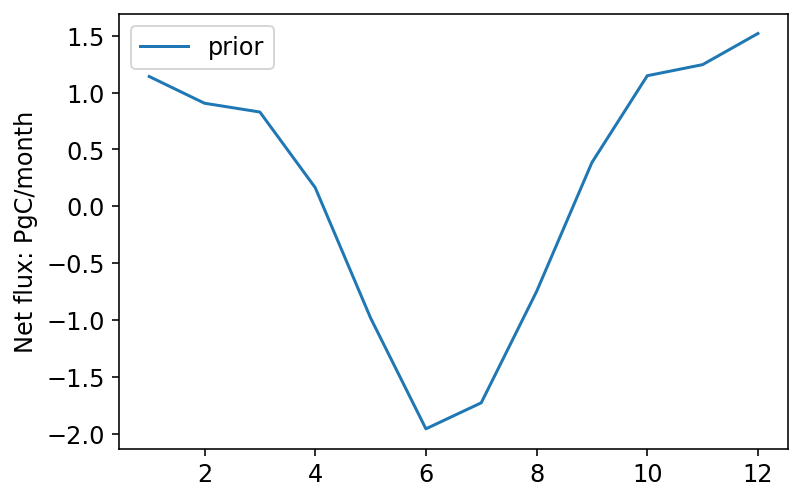

In [75]:
gl = []
for i in range(12):
    gl.append(sib_season[5][i] + odiac_season[5][i] + ann_total_C_original/12 + ocean_season[5][i])

fig = plt.figure(figsize=[6, 4])
plt.plot(range(1,13), gl, label = 'prior')
plt.ylabel('Net flux: PgC/month')
#plt.ylim(-2,2)
plt.legend()


In [76]:
# Fire
input_dir = '/geos/d21/GC_DATA/ExtData/HEMCO/'
fname = 'GFED4/v2020-02/2018/GFED4_gen.025x025.201801.nc'
ds_gfed  = xr.open_dataset(input_dir+fname)

# year 2018
lat_res = 0.25
lon_res = 0.25
varname = 'DM_TOTL'
unit    = ds_gfed[varname].attrs['units']
unit # kgDM/m2/s
ds_gfed

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
Data variables:
    DM_TOTL  (time, lat, lon) float32 ...
    DM_AGRI  (time, lat, lon) float32 ...
    DM_BORF  (time, lat, lon) float32 ...
    DM_DEFO  (time, lat, lon) float32 ...
    DM_SAVA  (time, lat, lon) float32 ...
    DM_PEAT  (time, lat, lon) float32 ...
    DM_TEMP  (time, lat, lon) float32 ...

In [77]:
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
veg_type = ['DM_AGRI', 'DM_BORF', 'DM_DEFO', 'DM_SAVA', 'DM_PEAT', 'DM_TEMP']
emission_factor = [1.585, 1.489, 1.643 ,1.686, 1.703, 1.647] # g of CO2 per kg dry matter burnt

In [78]:
monthly_total = np.zeros(12*6).reshape(12,6)
#monthly_total[0,:]

In [79]:
data = ds_gfed[varname].copy()
data

<xarray.DataArray 'DM_TOTL' (time: 1, lat: 720, lon: 1440)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
Attributes:
    units:    kg/m2/s

In [80]:
for i,imonth in enumerate(months):
    fname = 'GFED4/v2020-02/2018/GFED4_gen.025x025.2018' + imonth + '.nc'
    ds_gfed  = xr.open_dataset(input_dir+fname)
    
    for ivar,varname in enumerate(veg_type):
        data = ds_gfed[varname].copy()

        for ilat, lat in enumerate(data.lat):
            area_tmp = area_latlon(lat1 = lat, 
                                    lon1 = data.lon[10].values, 
                                    lat2 = lat + lat_res, 
                                    lon2 = data.lon[10].values + lon_res)
            data[0,ilat,:] = data[0,ilat,:] * area_tmp * 3600* 24 * days_in_month[i] *emission_factor[ivar] * 1e6 # unit: kgCO2/month
        monthly_total[i,ivar] = data.sum()*1e-12  # GtCO2/month
ann_total = sum(sum(monthly_total))*12/44  # GtC/year
print('annual total co2 emission (unit: GtC/yr):')
print(' ',ann_total)
print(' ')

annual total co2 emission (unit: GtC/yr):
  1.696792388476091
 


In [81]:
fire_season = []
for i in range(12):
    fire_season.append(sum(monthly_total[i]))

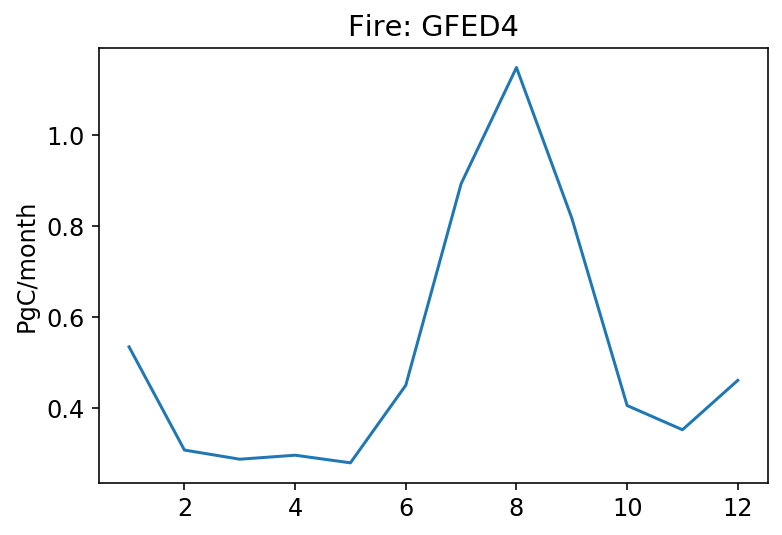

In [86]:

fig = plt.figure(figsize=[6, 4])
plt.plot(range(1,13), fire_season)
plt.title('Fire: GFED4')
plt.ylabel('PgC/month')
#plt.ylim(-2,2)

fig.savefig(output_dir + '/monthly_fire.png', dpi = 300)

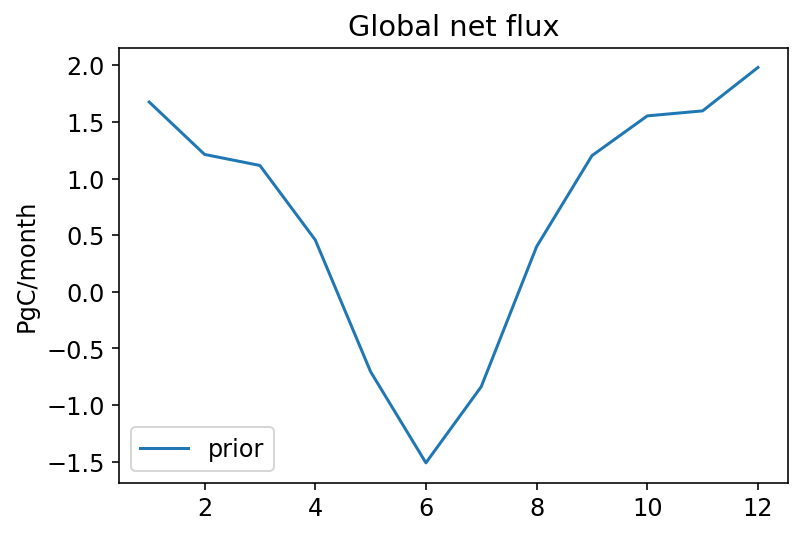

In [83]:
gl = []
for i in range(12):
    gl.append(sib_season[5][i] + odiac_season[5][i] + ann_total_C_original/12 + ocean_season[5][i] + fire_season[i])

fig = plt.figure(figsize=[6, 4])
plt.plot(range(1,13), gl, label = 'prior')
plt.title('Global net flux')
plt.ylabel('PgC/month')
#plt.ylim(-2,2)
plt.legend()

fig.savefig(output_dir + '/monthly_global.png', dpi = 300)

In [84]:
sum(gl)

<xarray.DataArray ()>
array(8.14543449)

NameError: name 'ann_total_C_liang' is not defined

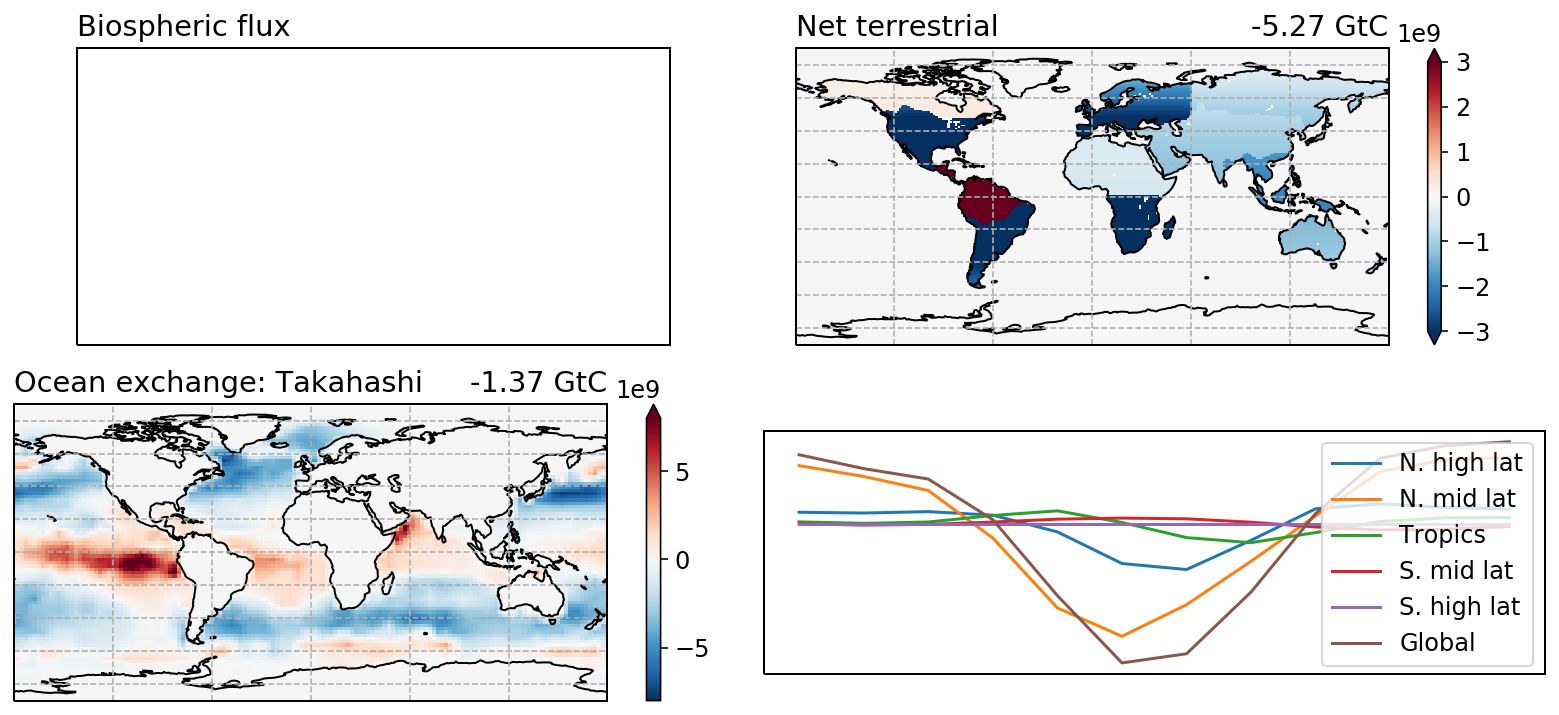

In [85]:
# plot all 4 fluxes together
fig, axes = plt.subplots(2, 2, 
                         figsize=[14, 6], 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'hspace': 0.2, 'wspace': 0})

# net terrestrial flux
for i in range(len(sib_season)):
    plt.plot(range(1,13), sib_season[i], label = lab[i])
plt.ylabel('PgC/month')
#plt.ylim(-2,2)
plt.legend()
axes[0,0].set_title('Biospheric flux', loc='left')


# net terrestrial flux
format_total_original = float("{0:.2f}".format(ann_total_C_original))
gc_total_original.plot(ax=axes[0,1], 
                       vmax = 3e9,
                       add_labels = False,
                       cbar_kwargs={'shrink': 1})
axes[0,1].set_title('Net terrestrial', loc='left')
axes[0,1].set_title(' ', loc = 'center')
axes[0,1].set_title(str(format_total_original) + ' GtC', loc = 'right')
axes[0,1].coastlines()
axes[0,1].gridlines(linestyle = '--')

# Ocean, Takahashi, 2009
format_total_ocean = float("{0:.2f}".format(ann_total_ocean))
ocean_annual.plot(ax=axes[1,0],
                    vmax = 8e9,
                    add_labels = False,
                    cbar_kwargs={'shrink': 1})
axes[1,0].set_title('Ocean exchange: Takahashi', loc='left')
axes[1,0].set_title(str(format_total_ocean) + ' GtC', loc = 'right')
axes[1,0].coastlines()
axes[1,0].gridlines(linestyle = '--')

# CASA
format_total_liang = float("{0:.2f}".format(ann_total_C_liang))
gc_total_liang.plot(ax=axes[1,1],
                    vmax = 3e9,
                    add_labels = False,
                    cbar_kwargs={'shrink': 1})
axes[1,1].set_title('CASA 2016', loc='left')
axes[1,1].set_title(str(format_total_liang) + ' GtC', loc = 'right')
axes[1,1].coastlines()
axes[1,1].gridlines(linestyle = '--')

output_dir = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data'
fig.savefig(output_dir + '/co2_fluxes.png', dpi = 300)